In [169]:
import cv2 as cv
import numpy as np
from PIL import Image
import tempfile

In [170]:
def set_image_dpi(file_path):       # Set image dpi for OCR engine
    im = Image.open(file_path)
    length_x, width_y = im.size
    factor = min(1, float(1024.0 / length_x))
    size = int(factor * length_x), int(factor * width_y)
    im_resized = im.resize(size, Image.ANTIALIAS)
    temp_file = tempfile.NamedTemporaryFile(delete=False,   suffix='.png')
    temp_filename = temp_file.name
    im_resized.save(temp_filename, dpi=(300, 300))
    return temp_filename

def image_binarisation(img):        # Use Otsu's binarisation
    blur = cv.GaussianBlur(img,(3,3),0)
    # blur = cv.medianBlur(img,5)
    ret,th = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    return th

def image_noise_removal(img):       # Remove noise from image
    im_nr = cv.fastNlMeansDenoising(img, 30.0, 7, 21)
    return im_nr

In [171]:
import cv2 as cv
import numpy as np
import pytesseract
from matplotlib import pyplot as plt

<ipython-input-172-cc51b79c1b70>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


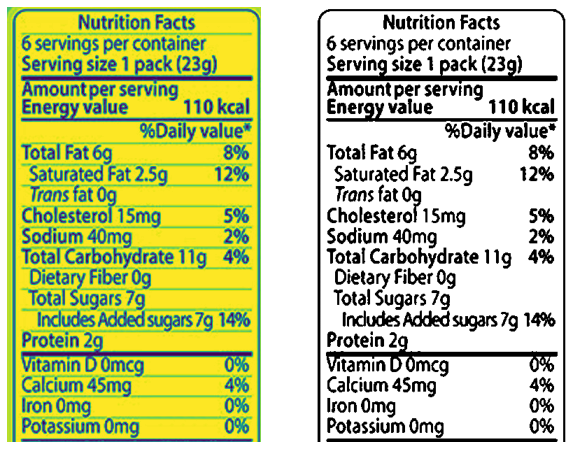

In [172]:
image_path = 'test_images/nf96.jpg'
img = cv.imread(image_path,0)  # read an image
img_dpi = set_image_dpi(image_path)
imgnew = cv.imread(img_dpi,0)   
img_bin = image_binarisation(imgnew)

fig = plt.figure(figsize=(10,10))
fig.add_subplot(1, 2, 1)
plt.axis("off")
plt.imshow(img)
fig.add_subplot(1, 2, 2)
plt.axis("off")
plt.imshow(img_bin,'gray')
fig.show()


In [ ]:
oem = 1
psm = 3
config = ('-l eng --oem {oem} --psm {psm}'.format(oem=oem,psm=psm))

pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

food_string = pytesseract.image_to_string(img_bin,lang = 'eng',config = config)
extractedText = open("Extracted_Text.txt",'w')
extractedText.write(food_string)
extractedText.close()

In [173]:
with open('Extracted_Text.txt','r') as f:
    print(f.read())

Nutrition Facts

6 servings per container

Serving size 1 pack (23g)

Amount per serving

Energy value 110 kcal

%Daily value*

Total Fat 6g 8%
Saturated Fat 2.59 12%
Trans fat

Cholesterol 15mg 5%

Sodium 40mg 2%

Total Carbohydrate 11g 4%

Dietary Fiber 0g
Total Sugars 79
Includes Added sugars 7g 14%
Protein a
itamin D Omcg
Calcium 45mg 4%
lron Omg 0%

Potassium Omg 0%



In [174]:
import pkg_resources
import re
from symspellpy import SymSpell, Verbosity

In [175]:
# Text parsing and nutrient data acquisition from file

with open('Extracted_Text.txt', 'r') as file :
  filedata = file.read()

# Replace the target string
filedata = filedata.replace('Og', '0g')
filedata = filedata.replace('Omg', '0mg')
filedata = filedata.replace('Omcg', '0mcg')
filedata = filedata.replace('_', '')
filedata = filedata.replace('of which', '')
filedata = filedata.replace('Of which', '')
filedata = filedata.replace('includes', '')
filedata = filedata.replace('Includes', '')

# Write the file out again
with open('Extracted_Text.txt', 'w') as file:
  file.write(filedata)

def change_to_g(text):                              # Used to change 9 to g. ex) Protein 109 ---> Protein 10g
    search_ln = re.search("\d\s|\d$", text)
    if search_ln and search_ln.group().strip() == "9":
        index = search_ln.span()[0]
        text = text[:index] +"g"+ text[index+1:]

    search_lnq = re.search("\dmq\s|\dmq$", text)
    if search_lnq:
        index = search_lnq.span()[0] +2
        text = text[:index] +"g"+ text[index+1:]
    return text

nutrientLineList = []

with open('Extracted_Text.txt', 'r') as file:
    line_list = file.readlines()
for line in line_list:
    newline = change_to_g(line)
    search_ln = re.findall(r"(((?:\w+[ ]+)+)(\d+\.*\d*[ ]*)([a-zA-Z]+))", newline)  # Find all sentences with format: Nutrient quantity unit
    try:
        nutrientLineList.append(list(search_ln[0][1:4]))
    except:
        pass

for nutrient in nutrientLineList:
    print(nutrient)

['Serving size ', '1 ', 'pack']
['Energy value ', '110 ', 'kcal']
['Total Fat ', '6', 'g']
['Saturated Fat ', '2.5', 'g']
['Cholesterol ', '15', 'mg']
['Sodium ', '40', 'mg']
['Total Carbohydrate ', '11', 'g']
['Dietary Fiber ', '0', 'g']
['Total Sugars ', '7', 'g']
['Added sugars ', '7', 'g']
['itamin D ', '0', 'mcg']
['Calcium ', '45', 'mg']
['lron ', '0', 'mg']
['Potassium ', '0', 'mg']


In [176]:
# Spell Checking and Correction using SymSpell

with open('nutrient.txt') as f:
    nutrientListMaster = f.read().splitlines()
nutrientListMaster = [word.lower() for word in nutrientListMaster]

def nutrientFinder(nutrient):
    for nutrientMaster in nutrientListMaster:
        if nutrient in nutrientMaster:
            return [True,nutrientMaster]
    return [False,nutrient]

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
corpus_path = "nutrient.txt"        # Custom list of nutrient names, which acts as the dictionary
sym_spell.create_dictionary(corpus_path)
sym_spell.load_dictionary(corpus_path, term_index=0, count_index=1)
nutrientLineList_corrected = []

for word in nutrientLineList:
    index = nutrientLineList.index(word)
    input_term = (word[0].lower())
    suggestions = sym_spell.lookup_compound(input_term, max_edit_distance=2)    # Find closest word in dictionary to the input
    for suggestion in suggestions:
        retVal = nutrientFinder(suggestion._term)
        if retVal[0] == True:
            nutrientLineList[index][0] = retVal[1]
            nutrientLineList_corrected.append(nutrientLineList[index])

for nutrient in nutrientLineList_corrected:
    print(nutrient)


['energy value', '110 ', 'kcal']
['total fat', '6', 'g']
['saturated fat', '2.5', 'g']
['cholesterol', '15', 'mg']
['sodium', '40', 'mg']
['total carbohydrate', '11', 'g']
['dietary fiber', '0', 'g']
['added sugars', '7', 'g']
['vitamin d', '0', 'mcg']
['calcium', '45', 'mg']
['iron', '0', 'mg']
['potassium', '0', 'mg']


In [178]:
import pandas as pd

NutritionTable = pd.DataFrame(columns = ["Nutrient","Quantity","Unit"])

for word in nutrientLineList_corrected:
    to_append = word
    df_length = len(NutritionTable)
    NutritionTable.loc[df_length] = to_append
    
NutritionTable.index += 1 
NutritionTable

,Nutrient,Quantity,Unit
1,energy value,110,kcal
2,total fat,6,g
3,saturated fat,2.5,g
4,cholesterol,15,mg
5,sodium,40,mg
6,total carbohydrate,11,g
7,dietary fiber,0,g
8,added sugars,7,g
9,vitamin d,0,mcg
10,calcium,45,mg
